In [78]:
import torch 
import torchvision 
import pytorch_lightning as pl 
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import  IterableDataset, DataLoader
import random
from torch.utils.data.sampler import WeightedRandomSampler
import math
import torch.nn as nn
import torch.nn.functional as F
import tensorboard
from torchmetrics import Accuracy
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

In [79]:
img = cv2.imread("d:/lab5dataset/Images/train/Angry/0.jpg", cv2.IMREAD_GRAYSCALE)

In [80]:
img = (img/255).astype(np.float32)

In [81]:
img.shape

(48, 48)

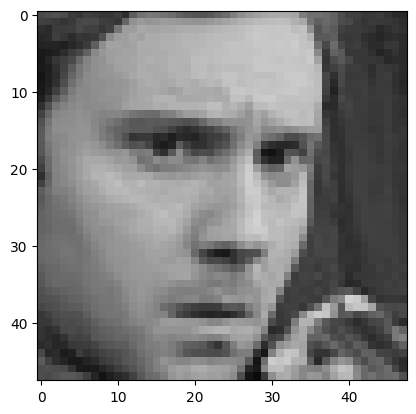

In [82]:
plt.imshow(img, cmap='gray', vmin=0, vmax=1)

In [83]:
class_info = sorted(
            [ d.name for d in os.scandir("D:/lab5dataset/Images/train") if d.is_dir()]
        )

class_info = dict(enumerate(class_info))

In [84]:
class_info

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Neutral',
 5: 'Sad',
 6: 'Surprise'}

In [85]:
class myDataset(IterableDataset):
    def __init__(self, root_dir, shuffle = True):
        super(myDataset).__init__()
        self.root_dir = root_dir
        self.shuffle = shuffle

        self.classes = sorted(
            [d.name for d in os.scandir(root_dir) if d.is_dir()]
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}


    def _get_file_paths(self):
        file_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for file in os.listdir(cls_dir):
                file_path = os.path.join(cls_dir, file)
                if os.path.isfile(file_path):
                    file_paths.append((file_path, cls))

        if self.shuffle:
            random.shuffle(file_paths)

        return file_paths


    

    def __iter__(self):
        file_paths = self._get_file_paths()
        worker_info = torch.utils.data.get_worker_info()
        
        if worker_info is None:  
            iter_start = 0
            iter_end = len(file_paths)
        else:  
            
            per_worker = int(math.ceil(len(file_paths) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(file_paths))
        
        for img_path, cls in file_paths[iter_start:iter_end]:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = (img / 255).astype(np.float32)
            label = self.class_to_idx[cls]
            yield img, label

In [86]:
dataset = myDataset("D:/lab5dataset/Images/train")

In [87]:
next(iter(dataset))

(array([[0.90588236, 0.85882354, 0.8509804 , ..., 0.54509807, 0.5529412 ,
         0.53333336],
        [0.85882354, 0.91764706, 0.9137255 , ..., 0.54901963, 0.4392157 ,
         0.48235294],
        [0.8117647 , 0.8980392 , 0.9098039 , ..., 0.6039216 , 0.4627451 ,
         0.27058825],
        ...,
        [0.80784315, 0.7647059 , 0.7137255 , ..., 0.47843137, 0.50980395,
         0.48235294],
        [0.7607843 , 0.78039217, 0.7137255 , ..., 0.49019608, 0.46666667,
         0.5254902 ],
        [0.6745098 , 0.8039216 , 0.7411765 , ..., 0.4392157 , 0.41568628,
         0.4627451 ]], dtype=float32),
 0)

In [88]:
batch_size = 128

In [89]:
class ImageModule (pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir, batch_size = batch_size, num_workers = 8):
        super().__init__()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
    


    def setup(self, stage=None):
        self.train_dataset = myDataset(
            root_dir=self.train_dir,
            shuffle=True
        )

        self.val_dataset = myDataset(
            root_dir=self.val_dir,
            shuffle=False
        )

        self.test_dataset = myDataset(
            root_dir= self.test_dir,
            shuffle=False
        )



    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )


In [90]:
"""


(batch_size, 1, 48,48) -> по 32 ядрам - (batch_size, 32, 48,48)
maxPool c ядром 2 -> (batch_size, 32, 24,24)

дальше аналогично по 64 фичам

и по 128 фичам

итог - (batch_size, 128,6,6)

дальше flatten

классификация = кроссэнтрония


""";

In [91]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes=7, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                           

            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                           

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                            
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )


        self.val_acc = Accuracy(task="multiclass", num_classes=7)
        self.train_acc = Accuracy(task='multiclass', num_classes=7)

        self.train_losses = []
        self.val_losses = []
        self.train_metrics = []
        self.val_metrics = []
        

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.train_acc(logits, y)

        self.train_losses.append(loss.item())
        self.train_metrics.append(acc.item())

        self.log_dict({
            "training/loss": loss,
            "training/acc": acc
        })

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.val_acc(logits, y)

        self.val_losses.append(loss.item())
        self.val_metrics.append(acc.item())

        self.log_dict({
            "val/loss": loss,
            "val/acc": acc
        })

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = self.test_acc(logits, y)
        self.log("test/acc", acc)
        return logits, y

    def on_train_epoch_end(self):
        avg_loss = sum(self.train_losses) / len(self.train_losses)
        avg_acc = sum(self.train_metrics) / len(self.train_metrics)


        print(f"Train epoch {self.current_epoch}. Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        self.train_losses.clear()
        self.train_metrics.clear()


    def on_validation_epoch_end(self):
        avg_loss = sum(self.val_losses) / len(self.val_losses)
        avg_acc = sum(self.val_metrics) / len(self.val_metrics)



        print(f"Val epoch {self.current_epoch}. Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        self.val_losses.clear()
        self.val_metrics.clear()




    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [92]:
datamodule = ImageModule(
    train_dir="D:/lab5dataset/Images/train",
    val_dir="D:/lab5dataset/Images/validation",
    test_dir="D:/lab5dataset/Images/test",
    batch_size=128,
    num_workers=0
)

In [93]:
model = SimpleCNN()

In [94]:
logger = TensorBoardLogger("tensorboardlogs")

In [95]:
trainer = Trainer(
    max_epochs=201,
    logger=logger,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=1,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 92.7 K | train
1 | fc_layers   | Sequential         | 1.2 M  | train
2 | val_acc     | MulticlassAccuracy | 0      | train
3 | train_acc   | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.098     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Val epoch 0. Avg Loss: 1.8947, Avg Acc: 0.0000


C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 0. Avg Loss: 1.6536, Avg Acc: 0.3434
Train epoch 0. Avg Loss: 1.7255, Avg Acc: 0.2996


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 1. Avg Loss: 1.5491, Avg Acc: 0.4165
Train epoch 1. Avg Loss: 1.4888, Avg Acc: 0.4243


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 2. Avg Loss: 1.5318, Avg Acc: 0.4420
Train epoch 2. Avg Loss: 1.3563, Avg Acc: 0.4821


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 3. Avg Loss: 1.4979, Avg Acc: 0.4530
Train epoch 3. Avg Loss: 1.2695, Avg Acc: 0.5158


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 4. Avg Loss: 1.5141, Avg Acc: 0.4705
Train epoch 4. Avg Loss: 1.1947, Avg Acc: 0.5473


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 5. Avg Loss: 1.4614, Avg Acc: 0.4854
Train epoch 5. Avg Loss: 1.1264, Avg Acc: 0.5738


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 6. Avg Loss: 1.4911, Avg Acc: 0.4914
Train epoch 6. Avg Loss: 1.0647, Avg Acc: 0.5983


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 7. Avg Loss: 1.5524, Avg Acc: 0.4877
Train epoch 7. Avg Loss: 0.9976, Avg Acc: 0.6252


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 8. Avg Loss: 1.4760, Avg Acc: 0.4998
Train epoch 8. Avg Loss: 0.9426, Avg Acc: 0.6474


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 9. Avg Loss: 1.5738, Avg Acc: 0.5045
Train epoch 9. Avg Loss: 0.8774, Avg Acc: 0.6700


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 10. Avg Loss: 1.7108, Avg Acc: 0.5009
Train epoch 10. Avg Loss: 0.8140, Avg Acc: 0.6950


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 11. Avg Loss: 1.7410, Avg Acc: 0.4968
Train epoch 11. Avg Loss: 0.7534, Avg Acc: 0.7207


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 12. Avg Loss: 1.8645, Avg Acc: 0.5102
Train epoch 12. Avg Loss: 0.6951, Avg Acc: 0.7399


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, datamodule):
    preds, targets = [], []

    trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu')
    test_loader = datamodule.test_dataloader()
    model.eval()

    with torch.no_grad():
        for x, y in test_loader:
            logits = model(x.cuda() if torch.cuda.is_available() else x)
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            targets.extend(y.cpu().numpy())

    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(model.hparams.num_classes))
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
trainer.test(model, datamodule=datamodule)
